### 2025년 6월 29일

# Synthetic 데이터 소개 및 활용 방법

[목차]
- 왜 사용해야 하는지 (실제 데이터 셋을 구하기 힘듦)
- 패키지는 어떻게 설계 되어있는지
- np.random과 비교
- Causalml 기본 문법에 대한 소개


In [ ]:
# 패키지 설치 (Colab 환경에는 패키지가 설치되어 있지 않음)
!pip install causalml
!pip install duecredit

In [57]:
import causalml
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from causalml.inference.meta import BaseSLearner, BaseTLearner, BaseXLearner, BaseRLearner, BaseDRLearner

## 🔍 왜 인과추론에서는 합성 데이터가 필요한가?

머신러닝 분석에서는, 주어진 데이터를 그대로 사용하여 모델을 학습하고 성능을 평가하는 것이 일반적입니다.

하지만 **인과추론(causal inference)**에서는 모델 성능이 아닌, 우리 데이터에 인과 구조가 얼마나 현실을 잘 반영하고, 인과 효과를 잘 추정할 수 있는지가 중요합니다.

그 이유는 인과추론의 근본적인 문제에서 비롯됩니다:
> *어떤 개체에 대해 우리는 처치 결과 \( Y(1) \) 또는 비처치 결과 \( Y(0) \) 둘을 동시에 관측할 수는 없습니다.*

즉, 실제 데이터에서는 **진짜 개별 처치효과 ( $\tau(x) = \mathbb{E}[Y(1) - Y(0) \mid X = x]$ )**를 알 수 없기 때문에, 모델의 정확도를 객관적으로 평가하기 어렵습니다.

반면, **합성 데이터(synthetic data)**를 사용하면 다음 요소들을 우리가 직접 정의할 수 있습니다:
- 데이터 생성 과정 (data-generating process),
- nuisance 함수들 (예: 기본 반응 함수 b(x), 처치 확률 e(x) )
- 그리고 참값인 개별 처치효과 $ \tau(x)\$

따라서, 모델이 예측한 $\hat{\tau}(x)$과 실제 $\tau(x)$ 사이의 오차(MSE 등)를 정확하게 계산할 수 있으며,  
**다양한 알고리즘을 통제된 조건에서 체계적으로 비교·검증**할 수 있게 됩니다.


In [4]:
# 합성 데이터를 사용하지 않은 선형 회귀를 이용한 인과 관계 확인 예시
# 데이터 생성
np.random.seed(42)
n = 1000
X = np.random.normal(0, 1, (n, 3))  # 3개의 독립 변수
T = np.random.binomial(1, 0.5, n)  # 처치 변수 (0 또는 1)

# 진짜 처치 효과 및 결과 변수 생성
tau = 2.0  # 처치 효과
Y = 3 * X[:, 0] + 2 * X[:, 1] + X[:, 2] + tau * T + np.random.normal(0, 1, n)

data = pd.DataFrame(np.concatenate([Y.reshape(-1, 1), T.reshape(-1, 1), X], axis=1),
                    columns=['Y', 'T', 'X0', 'X1', 'X2'])
data.head()

,Y,T,X0,X1,X2
0,4.042365,1.0,0.496714,-0.138264,0.647689
1,7.169924,1.0,1.523030,-0.234153,-0.234137
2,6.389199,0.0,1.579213,0.767435,-0.469474
3,1.822701,1.0,0.542560,-0.463418,-0.465730
4,-4.568393,0.0,0.241962,-1.913280,-1.724918


In [5]:
# sklearn의 Linear Regression을 사용한 회귀 분석
X_with_T = np.column_stack((X, T))  # 독립 변수에 처치 변수 추가
model = LinearRegression()
model.fit(X_with_T, Y)
coef = np.round(model.coef_[-1], 4)  # 처치 변수(T)의 회귀 계수
print("추정된 ATE (sklearn):", coef)

추정된 ATE (sklearn): 1.9887


위 예시처럼 임의의 데이터 셋을 만들고 효과를 검증하는 것보다, 더 과학적인 방법이 무엇이 있을까?

causalml 패키지 내, synthetic_data() 함수는 Nie & Wager (2018)에서 meta-learner 기반의 인과추정 알고리즘을 테스트하기 적합하게 만들어졌습니다. [Quasi-Oracle Estimation of Heterogeneous Treatment Effects](https://https://arxiv.org/abs/1712.04912)
(=R-leaner 논문)

_

왜 만들었을까? (목적)
- nuisance, treatment effect, propensity 함수의 복잡도에 따른 모델 성능 변화 분석  
- META learner(S, T, X, R-learner 등)의 구조에 따른 성능 비교
- 이론적 기대와 실제 구현 결과의 일치 여부 검증

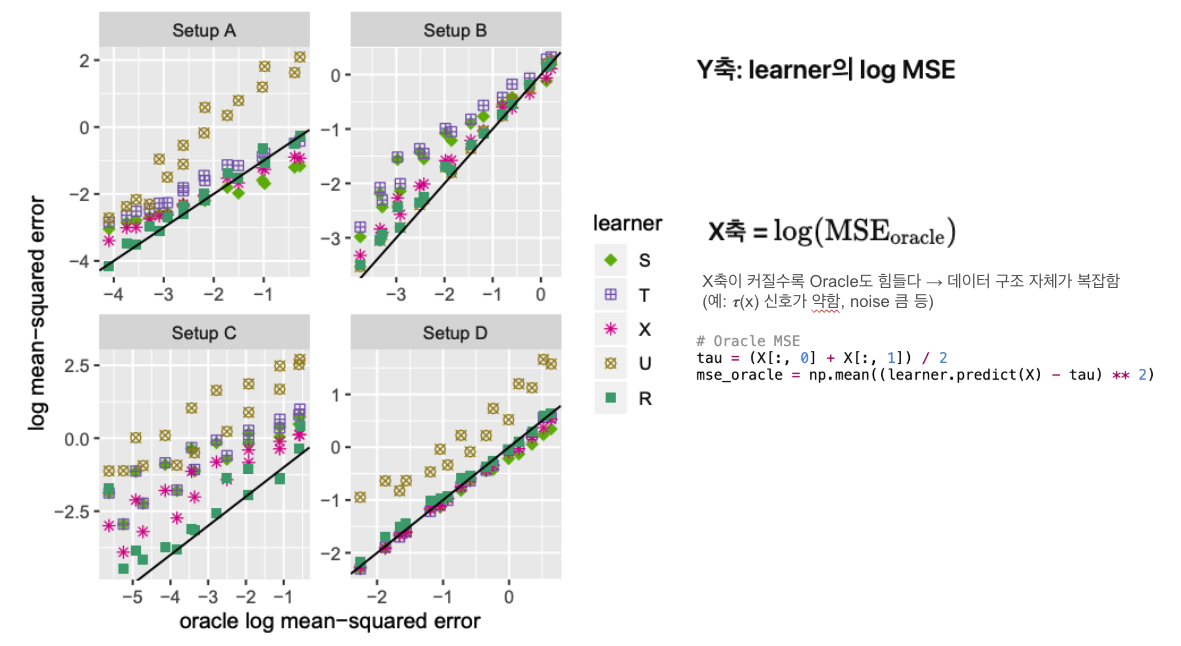

| Setup | mode | Propensity $e(x)$ | Baseline $b(x)$ | Treatment Effect $\tau(x)$ | 특징 요약 |
| :---: | :--: | :---------------: | :-------------: | :------------------------: | :-------------------- |
| **A** | 1 |      비선형, 복잡      |        복잡       |         **단순** (선형)        | nuisance 어렵고 $\tau$ 쉬움 |
| **B** | 2 |  **상수** (무작위 배정)  |        복잡       |           **단순** | 랜덤 실험 상황 |
| **C** | 3 |       **단순** |        복잡       |           **복잡** | $\tau$, $b$ 둘 다 어려움 |
| **D** | 4 |        다양함        |  **분리된 함수 구조** |           **복잡** | $b$와 $\tau$ 완전 독립 |

In [11]:
from causalml.dataset import synthetic_data

In [7]:
synthetic_data

<function causalml.dataset.regression.synthetic_data(mode=1, n=1000, p=5, sigma=1.0, adj=0.0)>

In [64]:
np.random.seed(41)
# 사용 방법
num_features = 5
Y, X, T, tau, b, e = synthetic_data(mode=1, n=10, p=num_features) # mode = 1에 대해 자세히 확인

In [65]:
Y # y = b + (treatment - 0.5) * tau + sigma * np.random.normal(size=n)

array([ 0.56362154,  2.1549076 ,  0.1596826 , -0.45546664, -0.16873669,
        0.54235342,  2.98998055, -0.06516782,  2.43368558, -0.90320413])

In [66]:
X # np.random.uniform(size=n * p).reshape((n, -1))

array([[0.25092362, 0.04609582, 0.67681624, 0.04346949, 0.1164237 ],
       [0.60386569, 0.19093066, 0.66851572, 0.91744785, 0.41878009],
       [0.33225985, 0.28303364, 0.18628227, 0.31711047, 0.48116867],
       [0.06952047, 0.70498257, 0.31467693, 0.74528235, 0.3982128 ],
       [0.60822646, 0.72845649, 0.42175804, 0.39390821, 0.23222257],
       [0.4416646 , 0.37302139, 0.58360604, 0.10003138, 0.74135188],
       [0.08319793, 0.12622394, 0.32289153, 0.64292729, 0.99947173],
       [0.28100165, 0.58222465, 0.87260106, 0.78933922, 0.21808769],
       [0.34662213, 0.72150064, 0.35391837, 0.4606843 , 0.24439766],
       [0.28266321, 0.82628147, 0.87437174, 0.142769  , 0.28007183]])

In [67]:
T # np.random.binomial(1, e, size=n)

array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0])

In [68]:
tau # tau = (X[:, 0] + X[:, 1]) / 2

array([0.14850972, 0.39739818, 0.30764674, 0.38725152, 0.66834147,
       0.407343  , 0.10471094, 0.43161315, 0.53406139, 0.55447234])

In [69]:
"""
np.sin(np.pi * X[:, 0] * X[:, 1])
        + 2 * (X[:, 2] - 0.5) ** 2
        + X[:, 3]
        + 0.5 * X[:, 4]
"""
b # 굉장히 복잡함

array([0.20053863, 1.53797896, 1.04569097, 1.16644209, 1.50630993,
       0.9794645 , 1.23838365, 1.66769627, 1.33286526, 1.23277146])

In [70]:
"""
eta = 0.1
e = np.maximum(
    np.repeat(eta, n),
    np.minimum(np.sin(np.pi * X[:, 0] * X[:, 1]), np.repeat(1 - eta, n)),
)
e = expit(logit(e) - adj)
"""
e # 굉장히 복잡함

array([0.1       , 0.35434597, 0.29115853, 0.15336406, 0.9       ,
       0.49477724, 0.1       , 0.4916501 , 0.70730244, 0.66965815])

In [71]:
# 실제로 S-learner에 활용해보기
# BaseSLearner 모델 학습
lrs = BaseSLearner(leaner = LinearRegression())

lrs.fit(X, T, Y) # fit
print(np.mean(lrs.predict(X))) # predict

# ATE 바로 구하기
ate, ate_lower_bound, ate_upper_bound = lrs.estimate_ate(X, T, Y, return_ci = True)
ate = np.round(ate[0], 4)
ate_lower_bound = np.round(ate_lower_bound[0], 4)
ate_upper_bound = np.round(ate_upper_bound[0], 4)

# 결과 출력
print("추정된 ATE (causalML):", ate)
print(f"추정된 ATE의 신뢰 구간: {ate_lower_bound} ~ {ate_upper_bound}")

-1.9942455394064702
추정된 ATE (causalML): -1.9942
추정된 ATE의 신뢰 구간: -2.7659 ~ -1.2226


# causalml 패키지는 어떻게 설계 되어있을까??

# CausalML 패키지의 3가지 핵심 특징

---

### 1. 친숙한 활용성
`scikit-learn`의 API 디자인을 채택하여, 대부분의 인과추론 모델에 통일된 사용법을 제공합니다.

- **`.fit(X, y, treatment)`**: 모델을 학습시킵니다.
    - `X`: 개인의 특성(features) 데이터
    - `y`: 결과(outcome) 변수
    - `treatment`: 처리(treatment) 여부 또는 종류를 나타내는 변수
- **`.predict(X)`**: 학습된 모델을 사용해 새로운 데이터 `X`에 대한 개인별 인과 효과(CATE)를 예측합니다.

---

### 2. 다양한 모델 종류

#### 메타-러너 (`causalml.inference.meta`)
기존의 지도학습 모델을 내부 부품처럼 사용하여 인과 효과를 추정하는 상위 레벨의 알고리즘입니다.

- **S-Learner**: 처치(`treatment`) 변수를 다른 특성 변수 중 하나로 취급하여 단일 모델로 학습. 구조가 간단하지만, 처치의 효과가 미미할 때 성능이 저하될 수 있습니다.
- **T-Learner**: 처치 그룹과 통제 그룹을 나누어 각각 별도의 모델을 학습시킨 뒤, 두 예측값의 차이로 인과 효과를 계산합니다.
- **X-Learner**: T-Learner를 기반으로 하되, 각 그룹의 정보를 교차 활용하여 편향(bias)을 줄이고 더 정교한 효과를 추정합니다.
- **R-Learner**: 손실 함수(loss function)를 변형하여 인과효과 자체를 직접 최적화하도록 설계된 고급 방법론입니다.

#### 🌳 트리 기반 방법론 (`causalml.inference.tree`)
어떤 특성을 가진 그룹에서 인과 효과가 크게 나타나는지 해석하기 용이한 장점이 있습니다.

- **CausalTree**: 인과 효과의 차이를 최대화하는 방향으로 가지를 분기하는 의사결정나무입니다.
- **CausalForest**: 여러 개의 `CausalTree`를 앙상블한 모델로, 더 안정적이고 신뢰도 높은 인과 효과를 추정합니다.

---

### 3. 평가 및 분석 도구
실제 정답 값을 알 수 없는 인과 효과를 효과적으로 평가하고 분석할 수 있는 다양한 유틸리티를 제공합니다.

- **Uplift Curve & AUUC (Area Under Uplift Curve)**
  - 모델이 인과 효과가 높은 순서대로 개인을 얼마나 잘 찾아내는지를 시각화하고 정량적으로 평가합니다. (마케팅 캠페인 등에서 반응할 사람을 타겟팅할 때 유용)
- **민감도 분석 (Sensitivity Analysis)**
  - 관찰되지 않은 교란 변수(confounder)가 결과에 얼마나 영향을 미칠 수 있는지 테스트하여 모델의 강건성(robustness)을 평가합니다.

# META 러너

## S 러너
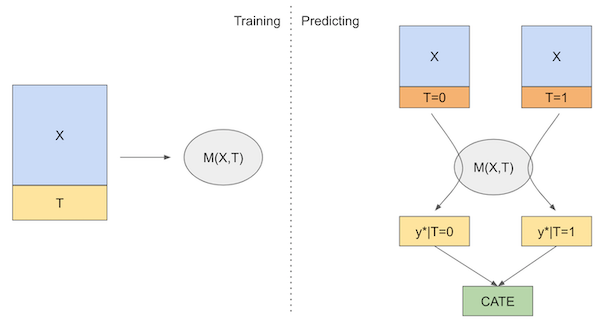

In [72]:
# BaseSLearner 모델 학습
lrs = BaseSLearner(learner = LinearRegression())

result = lrs.estimate_ate(X, T, Y, return_ci=False)
# 결과 출력
print("S Learner (ATE):", round(result[0], 4))

S Learner (ATE): -1.9942


## T 러너
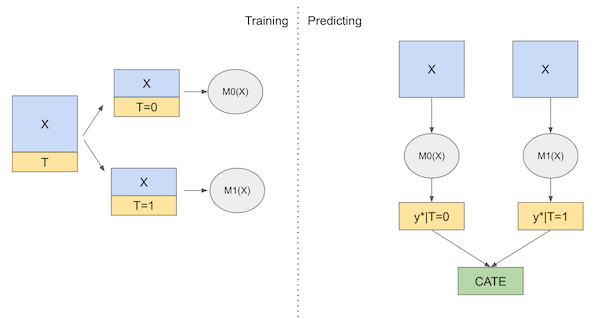

In [73]:
from xgboost import XGBRegressor

lrt = BaseTLearner(learner = LinearRegression(), control_learner = XGBRegressor())
ate, ate_lower, ate_upper = lrt.estimate_ate(X, T, Y)
# 결과 출력
print("T Learner (ATE):", round(ate[0], 4))

T Learner (ATE): -0.5169


## X 러너
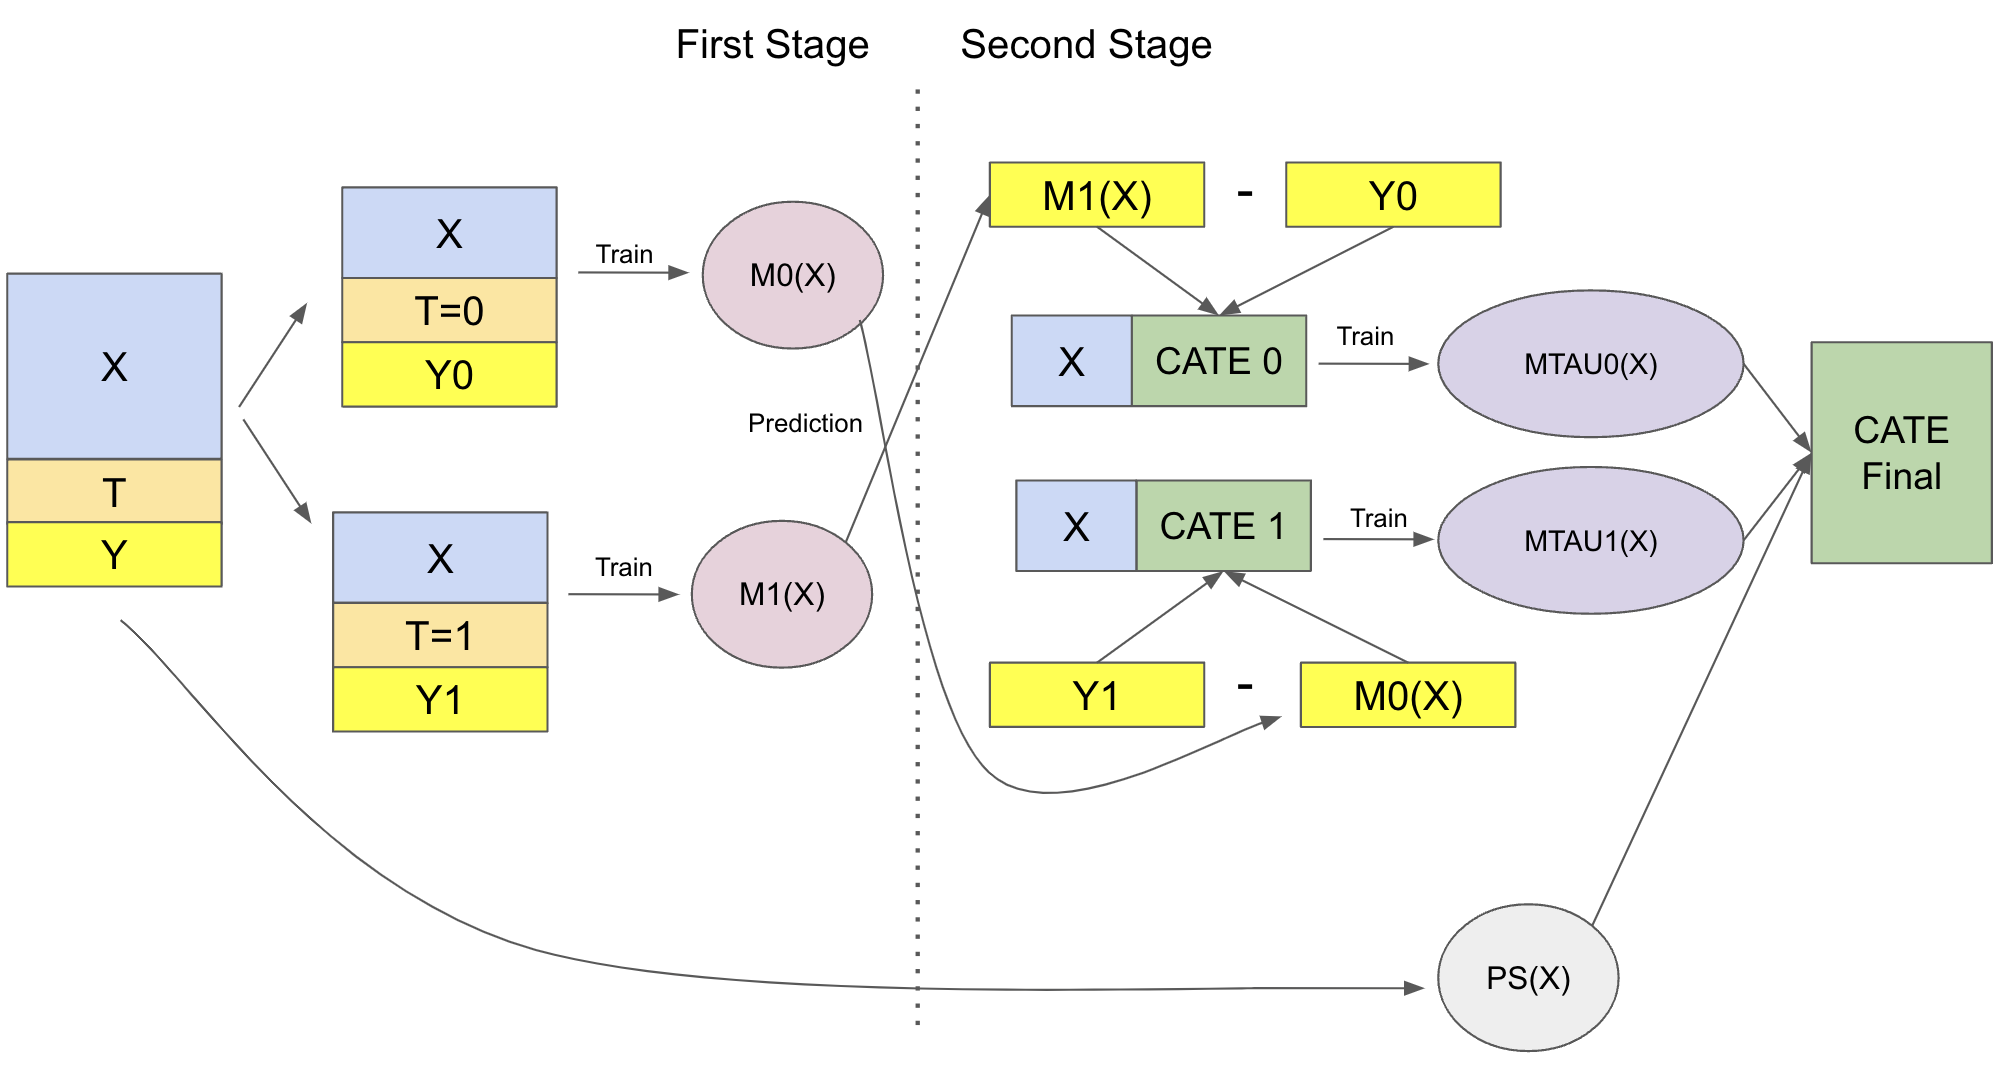

In [74]:
lrx = BaseXLearner(
    learner = LinearRegression(),
    control_outcome_learner = XGBRegressor(),
    treatment_outcome_learner = LinearRegression(),
    control_effect_learner = LinearRegression(),
    treatment_effect_learner = LinearRegression()
)
ate, ate_lower, atr_uuper = lrx.estimate_ate(X, T, Y)
# 결과 출력
print("X Learner (ATE):", round(ate[0], 4))

X Learner (ATE): -5.3378


In [75]:
lrx = BaseXLearner(
    learner = LinearRegression()
)
ate, ate_lower, atr_uuper = lrx.estimate_ate(X, T, Y)
# 결과 출력
print("X Learner (ATE):", round(ate[0], 4))

X Learner (ATE): -13.622
